In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gdal
import scipy
import scipy.stats
import os

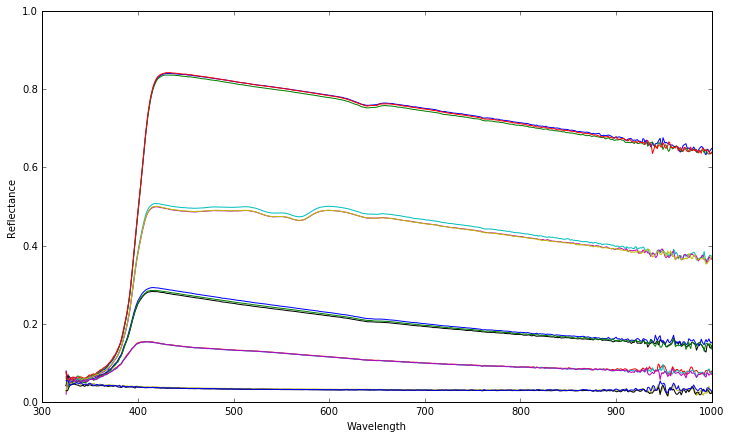

In [21]:
# input
#inFolder = '/Volumes/RASMUS_1/Field_data_2016/Iffiartafik_2016/Iffiartafik_spectroradiometer'
#specFile = 'spectro_iffiartafik_1535.txt'

inFolder = '/Volumes/RASMUS_1/Field_data_2016/Ersaa_2016/ersa_spectro'
specFile = 'spectro_ersaa_aug18_1300.txt'

###########################################
specFile = os.path.join(inFolder, specFile)
metaFile = os.path.join(inFolder, specFile[:-4] + '_meta.txt')
outFile = os.path.join(inFolder, specFile[:-4] + '_sequoia.txt')

seqSpecs = {'GRE':[530,570], 'RED':[640,680], 'REG':[730,740], 'NIR':[770,810]}

spec=pd.read_csv(specFile, sep=',',header=0)
header = list(spec)
spec = spec.values

meta = np.loadtxt(metaFile, delimiter=',', dtype='string')

chDict = {'GRE':[], 'RED':[], 'REG':[], 'NIR':[]}


specsOut = {'white':{'GRE':[], 'RED':[], 'REG':[], 'NIR':[]},
            'lightgrey':{'GRE':[], 'RED':[], 'REG':[], 'NIR':[]},
            'grey':{'GRE':[], 'RED':[], 'REG':[], 'NIR':[]},
            'darkgrey':{'GRE':[], 'RED':[], 'REG':[], 'NIR':[]},
            'black':{'GRE':[], 'RED':[], 'REG':[], 'NIR':[]}}
c = 1
for m in meta:
    f = plt.figure(c)
    ax = plt.gca()
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Reflectance')
    ax.set_xlim([300,1000])
    ax.set_ylim([0.0,1.0])
    
    for obs in m[1:]:
        i = header.index(obs)
        for ch in seqSpecs:
            specsOut[m[0]][ch].append(np.mean(spec[np.where(spec[:,0]==seqSpecs[ch][0])[0][0]:np.where(spec[:,0]==seqSpecs[ch][1])[0][0],i]))
        plt.plot(spec[:,0],spec[:,i])
        #plt.title(m[0])
        #plt.plot(seqSpecs[ch][0],0.5)
    #c += 1
    f.set_size_inches(12, 7)
    f.savefig(outFile[:-3] + 'png')

# save to csv
with open(outFile, 'w') as f:
    f.write('Refplate')
    for ch in chDict:
        f.write(',' + ch)
    for plate in specsOut:
        f.write('\n'+ plate)
        for ch in chDict:
            f.write(',' + str(np.mean(specsOut[plate][ch])))

In [5]:
refData = '/Users/rasmus/Desktop/sequoia_mask/Extracted_sequoia_ref_data.csv'
df = np.loadtxt(refData, delimiter=',',skiprows=1, dtype=np.str)

image_no = '0132'

ch = {1:'GRE', 2:'RED', 3:'REG', 4:'NIR'}
plate = {1:'black', 2:'darkgrey', 3:'grey', 4:'lightgrey', 5:'white'}

chDict = {'GRE':[[],[]], 'RED':[[],[]], 'REG':[[],[]], 'NIR':[[],[]]}

for d in df:
    img = d[0].split('_')
    if img[3] == image_no:
        for b in range(1,5):
            if d[1] == ch[b]:
                for p in range(1,6):
                    if d[2] == str(p):
                        if float(d[3]) < 65000: # sort out overexposed images
                            chDict[ch[b]][0].append(float(d[3]))
                            chDict[ch[b]][1].append(np.mean(specsOut[plate[p]][ch[b]]))

1: y = 9.88345674471e-06*x + -0.0498571853481     r2 = 0.72
1: y = 9.13174993534e-06*x + -0.066967637738     r2 = 0.99


2: y = 7.28674142383e-06*x + -0.0386442391942     r2 = 0.72
2: y = 8.44461071549e-06*x + -0.027604568569     r2 = 0.98


3: y = 1.28694919389e-05*x + -0.0402516979696     r2 = 0.85
3: y = 1.2691265573e-05*x + -0.061648906527     r2 = 0.99


4: y = 2.03371153807e-05*x + -0.0808686265037     r2 = 0.84
4: y = 1.48535062234e-05*x + -0.0783022446058     r2 = 0.99


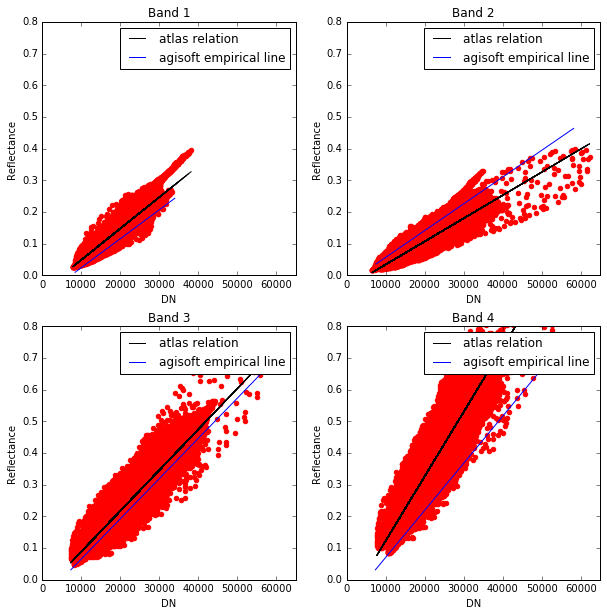

In [13]:
f1 = '/Volumes/btk596/temp/iffiartafik_seq_100m_v3_warp_clip_filt5.tif'
f2 = '/Volumes/btk596/temp/2016-08-15T16_30_53Z_BGREN_iffiartafik_filt5.tif'

xoffset = 1000
yoffset = 1000
count = 500

ds1 = gdal.Open(f1)
ds2 = gdal.Open(f2)
f = plt.figure(1)
f.set_size_inches(10, 10)
for bandNum in range(1,5):
    b1 = ds1.GetRasterBand(bandNum)
    a1 = b1.ReadAsArray(xoffset,yoffset,count,count)
    b2 = ds2.GetRasterBand(bandNum)
    a2 = b2.ReadAsArray(xoffset,yoffset,count,count).astype(np.float32)/32768
    
    ax = plt.subplot(220 + bandNum)
    ax.set_ylim([0.0,0.8])
    ax.set_xlim([0,65000])
    ax.scatter(a1, a2, color='red')
    plt.title('Band ' + str(bandNum))
    plt.xlabel('DN')
    plt.ylabel('Reflectance')
    
    # fit atlas data
    fit = np.polyfit(a1.flatten(),a2.flatten(),1)
    atlasLine = plt.plot(a1, fit[0] * a1 + fit[1], color='black')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(a1.flatten(), a2.flatten())
    print str(bandNum) + ': y = ' + str(fit[0]) + '*x + ' + str(fit[1]) + '     r2 = '+'{0:.2f}'.format(r_value*r_value)
    
    # fit reference plates
    c1 = chDict[ch[bandNum]][0]
    c2 = chDict[ch[bandNum]][1]
    fit2 = np.polyfit(c1, c2, 1)
    
    c1Mult = [x * fit2[0] for x in c1]

    empLine = plt.plot(c1, c1Mult + fit2[1], color='blue')
    plt.legend([atlasLine[0],empLine[0]], ['atlas relation','agisoft empirical line'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(c1, c2)
    print str(bandNum) + ': y = ' + str(fit2[0]) + '*x + ' + str(fit2[1]) + '     r2 = '+'{0:.2f}'.format(r_value*r_value)

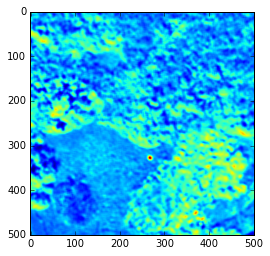

In [14]:
imgplot = plt.imshow(a1)